In [17]:
# !pip3 install opencv-python
# !apt-get update && apt-get install libgl1

import os

import numpy as np
from netCDF4 import Dataset

import seaborn as sns
from tqdm import tqdm
from glob import glob
import pandas as pd
import time

import matplotlib.pyplot as plt
import cv2

In [2]:
path = '/home/workspace'
data_path = os.path.join(path,'cmaqProjectdata')
proj_path = os.path.join(path,'repos','cmaqProject')

In [3]:
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_1_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_prefix

'/home/workspace/repos/cmaqProject/models/training_checkpoints/model_conmat_cmaq_1_checkpoint/ckpt'

In [4]:
BATCH_SIZE = 8
EPOCH = 1
shuffle_buffer_size = 100
train_set_len = 100

INPUT_SHAPE = [119]
OUTPUT_CHANNELS = 1

## 데이터셋

In [5]:
avg_conc_path_list = glob(os.path.join(data_path,"연평균자료","concentration","*"))
avg_conc_path_info_df = pd.DataFrame()
avg_conc_path_info_df.loc[:,'path'] = avg_conc_path_list
avg_conc_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_conc_path_list]

cont_matrix = pd.read_csv(os.path.join(data_path,"연평균자료","02_Emission_0518.csv"))

merged_info_df = pd.merge(avg_conc_path_info_df, cont_matrix, how='left', on='Run')
target_arr = np.concatenate([np.array(Dataset(path, 'r').variables['PM2_5'][0,0,8:-10,2:-1])[np.newaxis,:,:] for path in merged_info_df.path.tolist()])[:,:,:,None]

In [6]:
target_arr.shape

(120, 64, 64, 1)

In [7]:
input_cols = list(set(merged_info_df.columns) - set(['path','Run',]))

train_input = merged_info_df.loc[:,input_cols].values[:train_set_len]
test_input = merged_info_df.loc[:,input_cols].values[train_set_len:]

train_output = target_arr[:train_set_len]


# train_output_scaled = (train_output - train_min)/(train_max - train_min)
test_output = target_arr[train_set_len:]
# test_output_scaled = (test_output - train_min)/(train_max - train_min)

# train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
# train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

# test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
# test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


# train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
# test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)

# train_ds = ds.take(train_set_len) 
# test_ds = ds.skip(train_set_len)

In [10]:
train_output.shape

(100, 64, 64, 1)

## 모델

* 기본 트리

In [93]:
class Restree():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,

        # res_y_val: np.array,

        is_terminal: bool,

        # kernel_size: list,
        feature_n: int,

        input_shape: int,
        # pre_weak_net: Weakcnn,
        # pre_weak_net = None,

        # feature_list = [],


    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal
        self.y_val = y_val
        # # self.res_y_val = res_y_val
        # if self.i_depth != 0: # 사전모델 있는 첫노드가 아닌경우 이미 y값 잔차이기 때문에 그냥 쓰면됨
        #     # self.y_val = y_val   ### 여기서 모델 시작되자마자 y_val을 사전학습모델과 y와의 잔차로 피팅하기##
        #     # self.y_val = y_val - pre_weak_net(x_train).numpy() 
        #     self.y_val = y_val
            
        # else:
        #     self.y_val = y_val
        # # self.y_val = y_val - self.res_y_val

        

        

        self.x_val = x_val
        self.best_feature = None
        self.best_feature_value = None

        self.feature_n = feature_n# 30
        self.input_shape = input_shape # [70,64,64,3]

        self.pred_val = None # 갖는 이미지의 평균값, 피팅이 완료되면 y_val, x_val은 버리도록(메모리낭비)

        self.l_tree = None
        self.r_tree = None

        # ax1 = np.random.randint(input_shape[1] - kernel_size[0], size=kernel_n).reshape(-1,1)
        # ax2 = np.random.randint(input_shape[2] - kernel_size[1], size=kernel_n).reshape(-1,1)
        # ax3 = np.random.randint(input_shape[3], size=kernel_n).reshape(-1,1)

        self.feature_list = np.random.choice(range(self.input_shape),self.feature_n)

        # # self.weak_net = pre_weak_net


    # def obj_fun_bhattacharyya_dist(self, l_values, r_values):
        
    #     l_arr = np.float32(l_values)
    #     r_arr = np.float32(r_values)

    #     max_val = np.max(np.concatenate([l_arr,r_arr]))

    #     hist_cv_l = cv2.calcHist([l_arr],[0],None,[40],[0,max_val])
    #     hist_cv_r = cv2.calcHist([r_arr],[0],None,[40] ,[0,max_val])    #[100] 빈수, [0,256]값 범위 

    #     dist = cv2.compareHist(hist_cv_l, hist_cv_r, cv2.HISTCMP_BHATTACHARYYA) #작을수록 유사도큼

    #     return dist * -1

    def obj_fun_l1_loss(self, l_values, r_values):

        l_loss = np.mean((l_values - np.mean(l_values,axis =0))**2)
        r_loss = np.mean((l_values - np.mean(r_values,axis =0))**2)

        total_l = len(l_values) + len(r_values)

        weigted_loss = (l_loss*len(l_values) + r_loss*len(r_values))/total_l


        return weigted_loss

       
    def fit(self, ):
        best_score = None
        for cords in self.feature_list:  #컬럼_피처 루프
            
            feat_data = self.x_val[:,cords]


            # if len(set(feat_data.mean(axis = (1,2)))) == 1:

            #     ## 모든 kernel_cords에서 특징이 똑같은루프만 나오면 루프를 다 돌아도 best_score = None 상태로 남음
            #     ## 이상태에서 아래 피팅 부분으로 돌아가면 에러남
            #     continue
            # elif len(set(feat_data.mean(axis = (1,2)))) >= 100:
            #     selected_feat_vals = list(np.random.choice(list(set(feat_data.mean(axis = (1,2)))),100, replace = False))
            # else:
            #     selected_feat_vals = list(set(feat_data.mean(axis = (1,2))))
            try:
                selected_feat_vals = list(np.random.choice(list(feat_data),30, replace = False))
            except:
                selected_feat_vals = list(feat_data)
        

            for j in selected_feat_vals: #한 컬럼내에서 분류기준나누기 위한 루프

                left_ind = feat_data < j

                y_left = self.y_val[left_ind]
                y_right = self.y_val[~left_ind]

                if len(y_left) * len(y_right) != 0:

                    if self.best_feature is None:
                        self.best_feature = cords
                        self.best_feature_value = j
                        best_score = self.obj_fun_l1_loss(y_left, y_right)
                        
                    else:
                        new_score = self.obj_fun_l1_loss(y_left, y_right)
                        if new_score < best_score:
                            self.best_feature = cords
                            self.best_feature_value = j
                            best_score = new_score
                else:
                    continue

        if best_score is None:
            self.is_terminal = True
            # self.fit_weak_layer()
            
            return None
        
                        
        if self.max_depth >= self.i_depth:
            # 찾은 최적값으로 좌우 할당
            x_val_feat = self.x_val[:,self.best_feature]
    
            left_ind = x_val_feat < self.best_feature_value
            
            y_left = self.y_val[left_ind]
            y_right = self.y_val[~left_ind]

            x_left = self.x_val[left_ind]
            x_right = self.x_val[~left_ind]

            if len(y_left) > self.minimum_sample_leaf:
                # self.weak_net = pre_weak_net
                self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=False, feature_n=self.feature_n, input_shape=self.input_shape)
                self.l_tree.fit()
               
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_left) != 0 :
                    self.l_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_left, y_val = y_left, is_terminal=True, feature_n=self.feature_n, input_shape=self.input_shape)
                    # self.l_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
            if len(y_right) > self.minimum_sample_leaf:
                self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=False, feature_n=self.feature_n, input_shape=self.input_shape)
                self.r_tree.fit()
            else:
                #마지막 리프라서 피팅할필요 없이 y_val 평균으로 예측만 하면 됨
                #여기서 y_val이 없는 경우가 있음 이때 nan 리턴되서 에러, 먼저 해결
                if len(y_right) !=0:
                    self.r_tree = Restree(max_depth = self.max_depth,i_depth = self.i_depth + 1, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_right, y_val = y_right, is_terminal=True, feature_n=self.feature_n, input_shape=self.input_shape)
                    # self.r_tree.fit_weak_layer()
                else:
                    self.is_terminal = True
                    # self.fit_weak_layer()
        else:
            self.is_terminal = True
            # self.fit_weak_layer()

    def predict(self ,x_arr):
        # model
        feat_x = x_arr[:,self.best_feature]
        left_ind = feat_x < self.best_feature_value

        input_shape = x_arr.shape

        pred_val = np.zeros(shape=(input_shape[0],64,64,1))
        
        x_arr_left = x_arr[left_ind]
        x_arr_right = x_arr[~left_ind]

        if self.l_tree.is_terminal:
            # pred_l = self.l_tree.weak_net(x_arr_left)
            pred_l = self.l_tree.y_val.mean(axis = 0)
        else:
            pred_l = self.l_tree.predict(x_arr_left)

        if self.r_tree.is_terminal:
            # pred_r = self.r_tree.weak_net(x_arr_right)
            pred_r = self.r_tree.y_val.mean(axis = 0)
        else:
            pred_r = self.r_tree.predict(x_arr_right)
        
        pred_val[left_ind] = pred_l
        pred_val[~left_ind] = pred_r


        return pred_val



    def get_tree_structure(self):
        feat_list = []
        def get_info_dic(i_tree):
            result = {
            'best_feature': i_tree.best_feature,
            'best_feature_value': i_tree.best_feature_value,
            'terminal': i_tree.is_terminal,
            'depth': i_tree.i_depth,
            }
            if result['best_feature'] is not None:
                feat_list.append(result['best_feature'])
            
            if i_tree.l_tree is not None:
                result['l_tree'] = get_info_dic(i_tree.l_tree)
            
            if i_tree.r_tree is not None:
                result['r_tree'] = get_info_dic(i_tree.r_tree)

            return result
        
        info = get_info_dic(self)
        return info, feat_list

In [109]:
i_tree = Restree(max_depth = 30,i_depth = 0, minimum_sample_leaf = 1, x_val = train_input, y_val = train_output, is_terminal=False, feature_n=100, input_shape=119)
i_tree.fit()
            

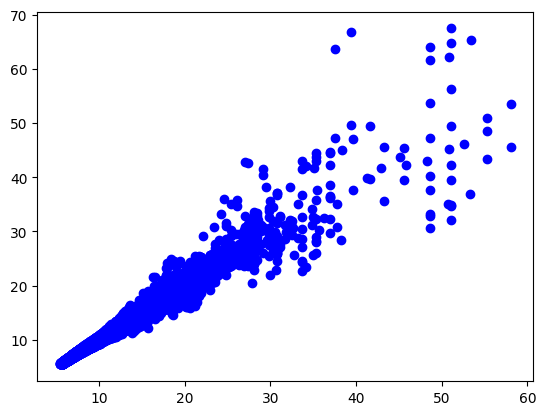

In [110]:
result = i_tree.predict(test_input)
plt.plot(result.reshape(-1), test_output.reshape(-1), 'bo')

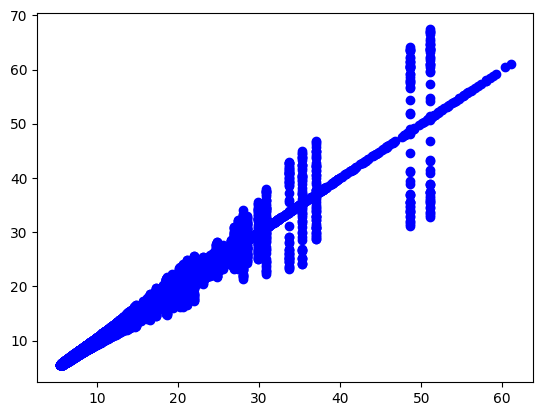

In [111]:
result = i_tree.predict(train_input)
plt.plot(result.reshape(-1), train_output.reshape(-1), 'bo')

* 배깅

In [97]:
class Bagging():
    def __init__(
        self,
        max_depth: float,
        i_depth: float,
        minimum_sample_leaf: float,
        y_val: np.array,
        x_val: np.array,
        is_terminal: bool,

        feature_n: int,

        input_shape: list,

        n_tree: int,

        
    ):
        self.max_depth = max_depth
        self.minimum_sample_leaf = minimum_sample_leaf
        self.i_depth = i_depth
        self.is_terminal = is_terminal

        self.y_val = y_val
        self.x_val = x_val

      
        self.feature_n = feature_n# 30
        self.input_shape = input_shape # [70,64,64,3]
        
        self.tree_bootstrap = []
        self.n_tree = n_tree

    def bagging_prediction(self,x_vals):
        print(x_vals.shape)
        preds = np.mean([ind_tree.predict(x_vals) for ind_tree in self.tree_bootstrap], axis = 0)
        return preds


    def bagging_train(self,):
        for i in range(self.n_tree):
            print(i)
            data_len = len(self.x_val)
            sub_sample_ind = np.random.choice(range(data_len),data_len)
            x_val_bootstraped = self.x_val[sub_sample_ind]
            y_val_bootstraped = self.y_val[sub_sample_ind]

            i_tree = Restree(max_depth = self.max_depth,i_depth = 0, minimum_sample_leaf = self.minimum_sample_leaf, x_val = x_val_bootstraped, y_val = y_val_bootstraped, is_terminal=False, feature_n=self.feature_n, input_shape=len(x_val_bootstraped[0,:]))
            i_tree.fit()
            self.tree_bootstrap.append(i_tree)
           
    

In [113]:
input_arr_list = []
output_arr_list = []

input_arr_list.append(train_input)
output_arr_list.append(train_output)

for val in [63]:
    max_list = np.array([np.max(train_output[i]) for i in range(len(train_output))])
    sample_ind = np.random.choice(np.array(range(len(train_input)))[max_list > val], 30, replace = True)

    oversample_input = train_input[sample_ind]
    oversample_output = train_output[sample_ind]

    input_arr_list.append(oversample_input)
    output_arr_list.append(oversample_output)

newinput = np.concatenate(input_arr_list, axis = 0)
newoutput = np.concatenate(output_arr_list, axis = 0)



bagging_tree = Bagging(
    max_depth= 30,
    i_depth= 0,
    minimum_sample_leaf= 1,
    y_val= newoutput,
    x_val= newinput,
    is_terminal= False,

    feature_n= 100,

    input_shape= len(train_input[0,:]),

    n_tree= 10,
)

bagging_tree.bagging_train()

0
1
2
3
4
5
6
7
8
9


(100, 119)


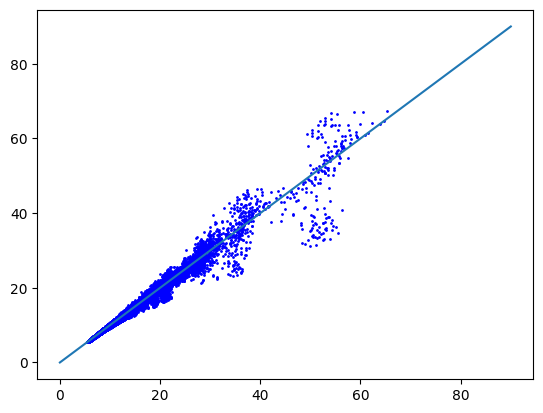

In [114]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred = bagging_tree.bagging_prediction(train_input)
plt.plot(pred.reshape(-1), train_output.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

(20, 119)


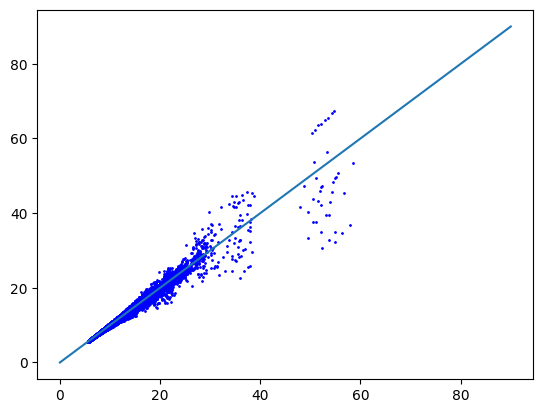

In [115]:
# 6분, 데이터셋 작을때는 gpu올리는 시간이 더 오래걸리기 때문에 그냥하는 것이 더 빠름
pred_test = bagging_tree.bagging_prediction(test_input)
plt.plot(pred_test.reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])